In [1]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')

from matplotlib import cm
from tqdm import tqdm
from scipy import interpolate
import time
from tslearn import metrics
from tslearn.metrics import dtw, dtw_path
from scipy.spatial.distance import cdist
from numba import njit, prange
import numba

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')
import stumpy  # local load

## Load dataset

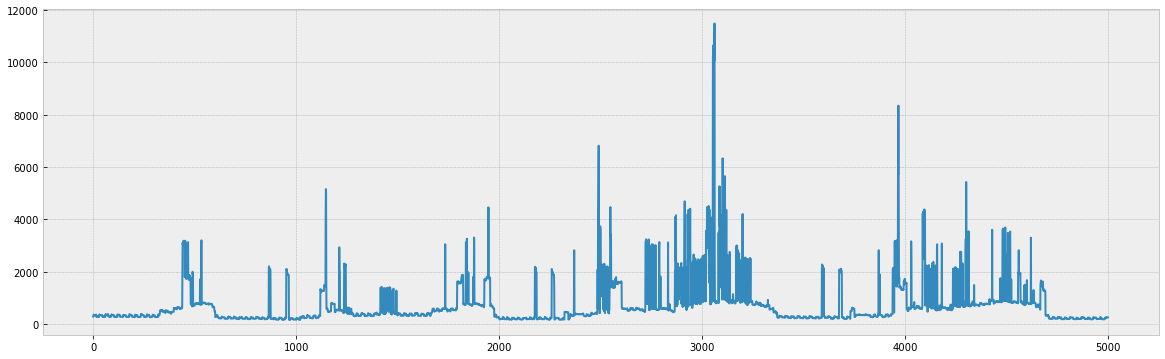

In [42]:
dfx = pd.read_csv("house_5__18days.txt")
v = dfx.values[:, 0]
v0 = v[:5000]
plt.plot(v0)
plt.show()

# 1.SWAMP Algorithm
From paper

<img src="images_dtw/paper_SWAMPc.png" width="600">
<img src="images_dtw/paper_computeDSMPc.png" width="600">
<img src="images_dtw/paper_LBDSMPc.png" width="600">

### A:
Prepare best-so-far which is indicator to reject calculation of DTW.

<img src="images_dtw/paper_1.png" width="600">

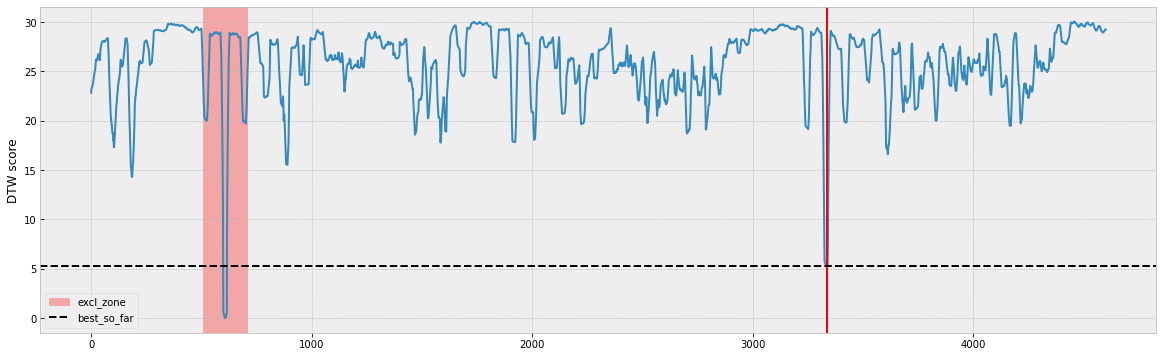

In [3]:
T_A = v0.astype(np.float64) # input 
m = 400 # input 
r = 8 # input 

# ED_mp
ED_mp = stumpy.stump(T_A, m)

# ED_motif_idx
ED_motif_idx = np.argmin(ED_mp[:, 0])

# best-so-far
n_A = T_A.shape[0]
ED_motif = T_A[ED_motif_idx:ED_motif_idx+m]

dtw_dist = stumpy.dtw_dist(ED_motif, T_A, r)

excl = int(np.ceil(m/4))
idx_excl_start = ED_motif_idx - excl if ED_motif_idx - excl >= 0 else 0
idx_excl_end = ED_motif_idx + excl if ED_motif_idx + excl <= n_A-m+1 else 0
idx_dist_ = np.arange(n_A -m +1)
idx_dist = np.hstack([idx_dist_[:idx_excl_start], idx_dist_[idx_excl_end:]])

idx_best_so_far_ = np.argmin(np.hstack([dtw_dist[:idx_excl_start], dtw_dist[idx_excl_end:]]))
idx_best_so_far = idx_dist[idx_best_so_far_]
best_so_far = dtw_dist[idx_best_so_far]

# pruned
mask_pruned = np.full(n_A-m+1, False)

plt.plot(dtw_dist)
plt.axvspan(idx_excl_start, idx_excl_end, color="red", alpha=0.3, label="excl_zone")
plt.axvline(idx_best_so_far, color="r")
plt.axhline(best_so_far, color="k", linestyle="--", label="best_so_far")
plt.ylabel("DTW score")
plt.legend()
plt.show()

### B:

DS LBMP prune for reducing candidate pair for dtw top-motif by 98%.

<img src="images_dtw/paper_2.png" width="600">

**In paper code, best-so-far is updated in each DS calculation.  
It won't work properly, in matlab code it isn't updated. That's waht I used.**

### B: Pruned example in paper
<img src="images_dtw/paper_cumPruned.png" width="700">

#### Each downsample rate LBMP (20:1~1:1)

From here, DS LBMP is calculated by rough DS rate to finer rate.
DS LBMP area above best_so_far is pruned.  
Pruned index should be succeeded to finer sampling rate in calculating.  
Ex) On pruned index on DS_32, DS_16 MP doesn't calculate distance.

##### 20:1 

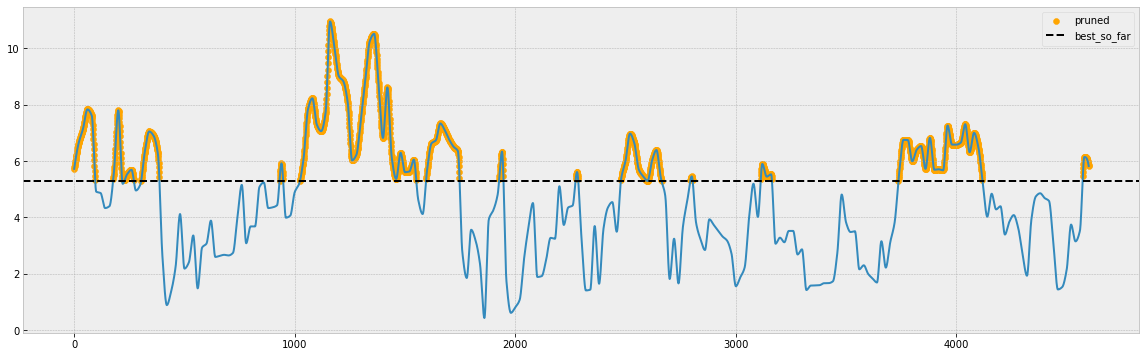

In [8]:
cal_time = []
D_list = [20, 5, 2, 1]
i_D = 0

ut0 = time.time()
mp_D = stumpy.lbKeogh_DSMP(v0, m, D_list[i_D], r)
cal_time.append(time.time()-ut0)

idx_pruned_20 = mp_D > best_so_far
x_i = np.arange(len(mp_D))

plt.plot(mp_D)
plt.scatter(x_i[idx_pruned_20], mp_D[idx_pruned_20], color="orange", label="pruned")
plt.axhline(best_so_far, color="k", linestyle="--", label="best_so_far")
plt.legend()
plt.show()

##### 5:1

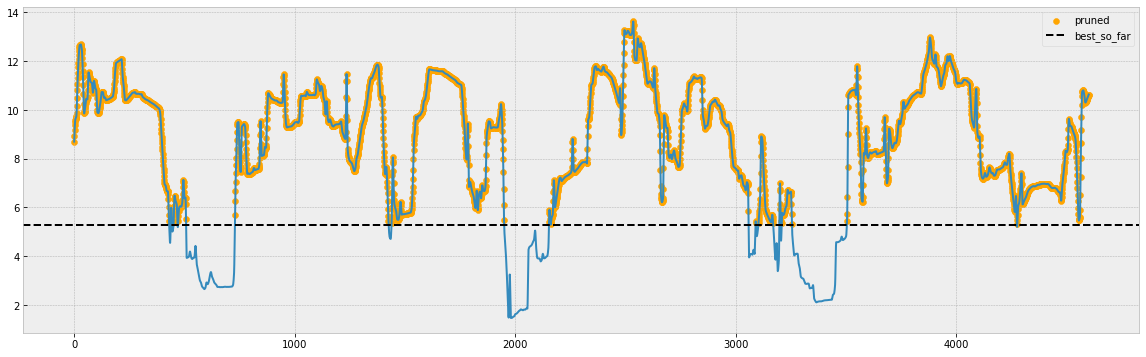

In [9]:
i_D = 1
ut0 = time.time()
mp_D = stumpy.lbKeogh_DSMP(v0, m, D_list[i_D], r)
cal_time.append(time.time()-ut0)

idx_pruned_5 = mp_D > best_so_far
x_i = np.arange(len(mp_D))

plt.plot(mp_D)
plt.scatter(x_i[idx_pruned_5], mp_D[idx_pruned_5], color="orange", label="pruned")
plt.axhline(best_so_far, color="k", linestyle="--", label="best_so_far")
plt.legend()
plt.show()

##### 2:1

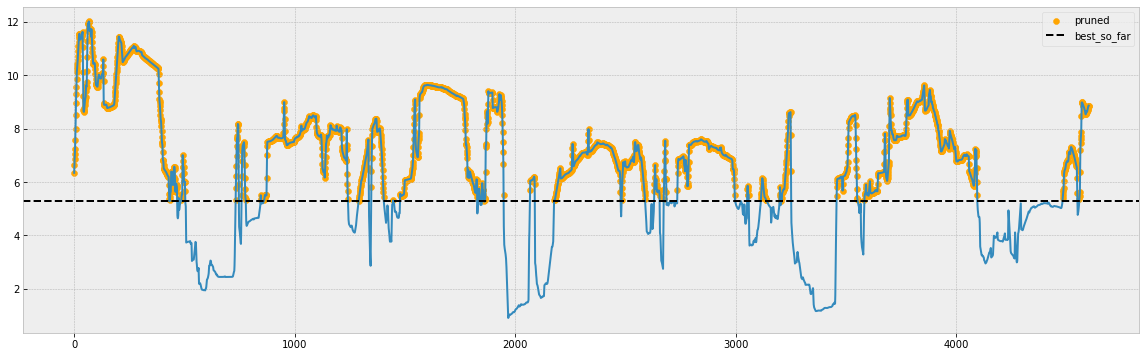

In [10]:
i_D = 2
ut0 = time.time()
mp_D = stumpy.lbKeogh_DSMP(v0, m, D_list[i_D], r)
cal_time.append(time.time()-ut0)

idx_pruned_2 = mp_D > best_so_far
x_i = np.arange(len(mp_D))

plt.plot(mp_D)
plt.scatter(x_i[idx_pruned_2], mp_D[idx_pruned_2], color="orange", label="pruned")
plt.axhline(best_so_far, color="k", linestyle="--", label="best_so_far")
plt.legend()
plt.show()

##### 1:1

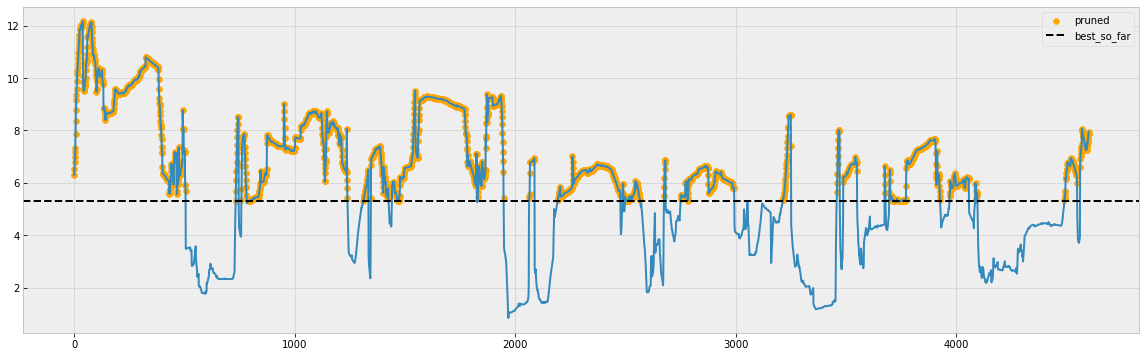

In [11]:
ut0 = time.time()
mp_D = stumpy.lbKeogh_MP(v0, m, r)[0]
cal_time.append(time.time()-ut0)
idx_best_mp_D = np.argmin(mp_D)

idx_pruned_1 = mp_D > best_so_far
x_i = np.arange(len(mp_D))

plt.plot(mp_D)
plt.scatter(x_i[idx_pruned_1], mp_D[idx_pruned_1], color="orange", label="pruned")
plt.axhline(best_so_far, color="k", linestyle="--", label="best_so_far")
plt.legend()
plt.show()

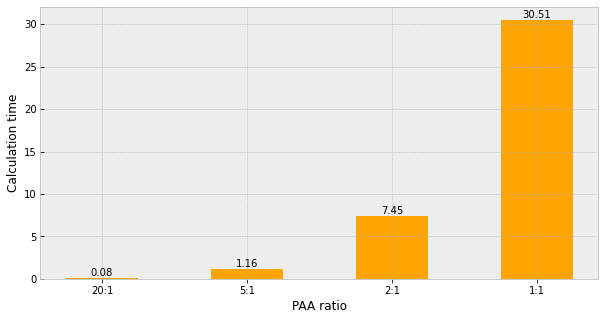

In [16]:
plt.figure(figsize=(10, 5))
hbars = plt.bar(["20:1", "5:1", "2:1", "1:1"], cal_time, label=D_list, color="orange", width=0.5)
plt.bar_label(hbars, fmt='%.2f')
plt.ylabel("Calculation time")
plt.xlabel("PAA ratio")
plt.show()

#### Each downsample rate LBMP (20:1~1:1) with pruning index
##### 20:1

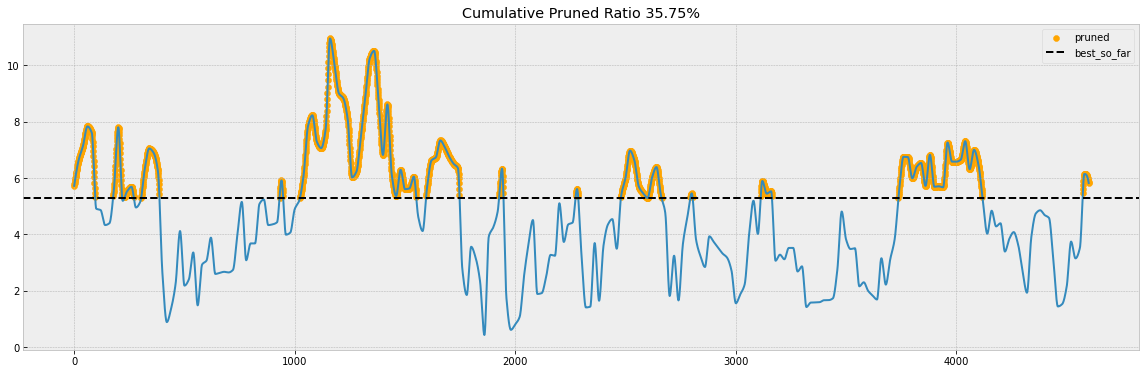

In [17]:
cal_time2 = []
T_A = v0.astype(np.float64) # input 
m = 400 # input 
r = 8 # input 
D_list = [20, 5, 2, 1]
i_D = 0

ut0 = time.time()
mp_D = stumpy.lbKeogh_DSMP(v0, m, D_list[i_D], r)
cal_time2.append(time.time()-ut0)
best_so_far_20 = np.min(mp_D)

idx_pruned_20 = mp_D > best_so_far
indices_pruned_20 = np.where(idx_pruned_20==True)[0]
x_i = np.arange(len(mp_D))

plt.plot(mp_D)
plt.scatter(x_i[idx_pruned_20], mp_D[idx_pruned_20], color="orange", label="pruned")
plt.axhline(best_so_far, color="k", linestyle="--", label="best_so_far")
plt.legend()
plt.title(f"Cumulative Pruned Ratio {np.sum(idx_pruned_20)/len(mp_D)*100:.2f}%")
plt.show()

##### 5:1

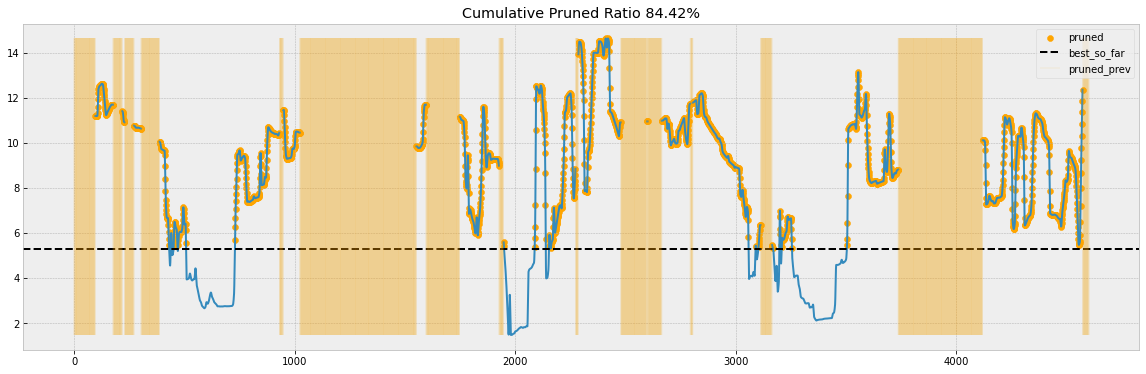

In [18]:
i_D = 1
ut0 = time.time()
mp_D = stumpy.lbKeogh_DSMP(v0, m, D_list[i_D], r, indices_pruned=indices_pruned_20)
cal_time2.append(time.time()-ut0)
best_so_far_5 = np.min(mp_D)

idx_pruned_5 = np.logical_or(mp_D > best_so_far, idx_pruned_20)
indices_pruned_5 = np.where(idx_pruned_5==True)[0]
x_i = np.arange(len(mp_D))

plt.plot(mp_D)
plt.scatter(x_i[idx_pruned_5], mp_D[idx_pruned_5], color="orange", label="pruned")
plt.axhline(best_so_far, color="k", linestyle="--", label="best_so_far")
# plt.axhline(best_so_far_20, color="r", linestyle="--", label="best_so_far_5")
plt.vlines(x_i[idx_pruned_20], np.min(mp_D), np.max(mp_D[mp_D!=np.inf]), color="orange",
        alpha=0.05, label="pruned_prev")
plt.legend()
plt.title(f"Cumulative Pruned Ratio {np.sum(idx_pruned_5)/len(mp_D)*100:.2f}%")
plt.show()

##### 2:1

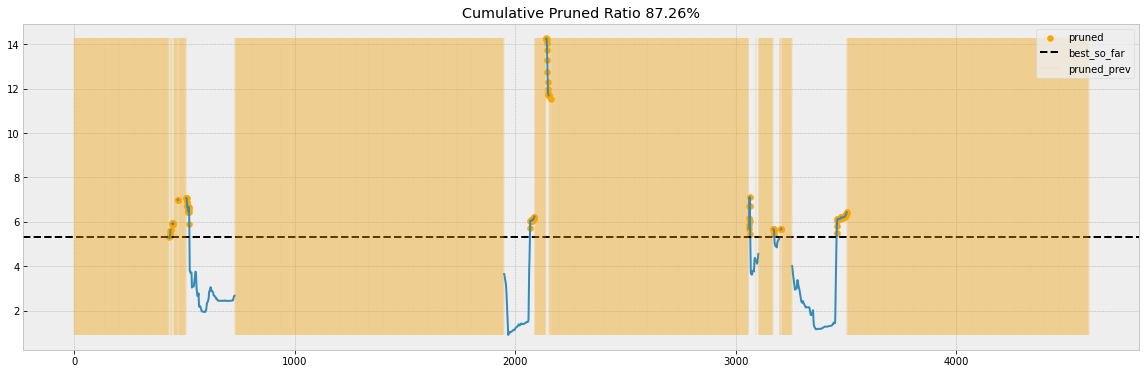

In [19]:
i_D = 2
ut0 = time.time()
mp_D = stumpy.lbKeogh_DSMP(v0, m, D_list[i_D], r, indices_pruned=indices_pruned_5)
cal_time2.append(time.time()-ut0)
best_so_far_2 = np.min(mp_D)

idx_pruned_2 = np.logical_or(mp_D > best_so_far, idx_pruned_5)
indices_pruned_2 = np.where(idx_pruned_2==True)[0]
x_i = np.arange(len(mp_D))

plt.plot(mp_D)
plt.scatter(x_i[idx_pruned_2], mp_D[idx_pruned_2], color="orange", label="pruned")
plt.axhline(best_so_far, color="k", linestyle="--", label="best_so_far")
# plt.axhline(best_so_far_5, color="r", linestyle="--", label="best_so_far_5")
plt.vlines(x_i[idx_pruned_5], np.min(mp_D), np.max(mp_D[mp_D!=np.inf]), color="orange",
        alpha=0.05, label="pruned_prev")
plt.legend()
plt.title(f"Cumulative Pruned Ratio {np.sum(idx_pruned_2)/len(mp_D)*100:.2f}%")

plt.show()

##### 1:1

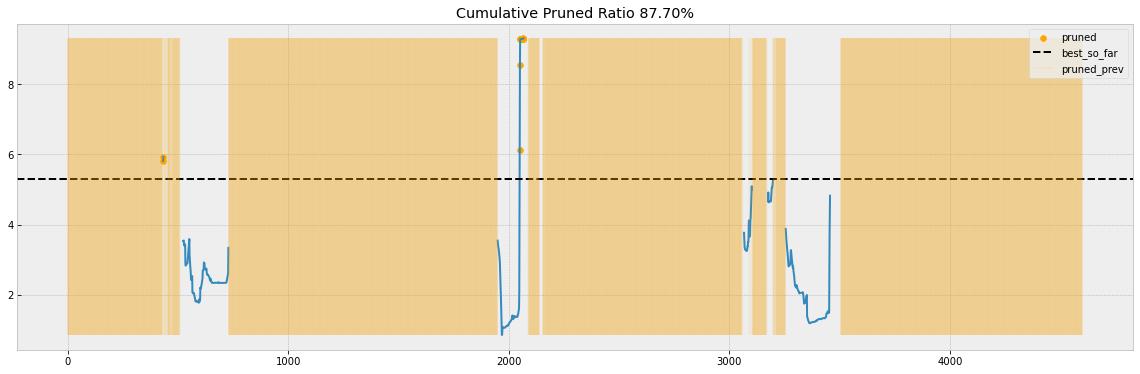

In [20]:
ut0 = time.time()
mp_ = stumpy.lbKeogh_MP(v0, m, r, indices_pruned=indices_pruned_2)
mp_D = mp_[0]
cal_time2.append(time.time()-ut0)
best_so_far_1 = np.min(mp_D)

idx_pruned_1 = np.logical_or(mp_D > best_so_far, idx_pruned_2)
indices_pruned_1 = np.where(idx_pruned_1==True)[0]
x_i = np.arange(len(mp_D))

plt.plot(mp_D)
plt.scatter(x_i[idx_pruned_1], mp_D[idx_pruned_1], color="orange", label="pruned")
plt.axhline(best_so_far, color="k", linestyle="--", label="best_so_far")
# plt.axhline(best_so_far_5, color="r", linestyle="--", label="best_so_far_5")
plt.vlines(x_i[idx_pruned_5], np.min(mp_D), np.max(mp_D[mp_D!=np.inf]), color="orange",
        alpha=0.05, label="pruned_prev")
plt.legend()
plt.title(f"Cumulative Pruned Ratio {np.sum(idx_pruned_1)/len(mp_D)*100:.2f}%")

plt.show()

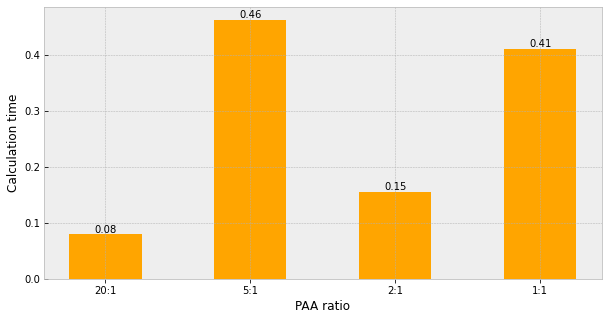

In [21]:
plt.figure(figsize=(10, 5))
hbars = plt.bar(["20:1", "5:1", "2:1", "1:1"], cal_time2, label=D_list, color="orange", width=0.5)
plt.bar_label(hbars, fmt='%.2f')
plt.ylabel("Calculation time")
plt.xlabel("PAA ratio")
plt.show()

#### Speed comparison (much faster)

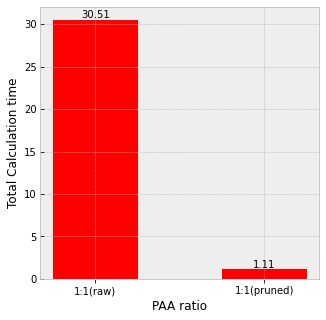

In [39]:
name_ = ["1:1(raw)", "1:1(pruned)"]
plt.figure(figsize=(5, 5))
hbars = plt.bar(name_, [cal_time[-1], np.sum(cal_time2)], color="red", width=0.5)
plt.bar_label(hbars, fmt='%.2f')
plt.ylabel("Total Calculation time")
plt.xlabel("PAA ratio")
plt.show()

---

### C:
Finally, DTW calculation time with pruned index

<img src="images_dtw/paper_3.png" width="600">

In [29]:
candids_i = np.where(idx_pruned_1==False)[0]
candids_index = mp_[1][candids_i]

In [37]:
m = 400 # input 
r = 8 # input 
dtw_score = []
for i in range(len(candids_i)):
    v_a = v0[candids_i[i]:candids_i[i]+m]
    v_b = v0[candids_index[i]:candids_index[i]+m]
    m_a, std_a = np.mean(v_a), np.std(v_a)
    m_b, std_b = np.mean(v_b), np.std(v_b)    
    va_z = (v_a-m_a)/std_a
    vb_z = (v_b-m_b)/std_b
    # Lb kim => skip (due to z-normalized)

    # Lb keogh => skip (last D in last DSLBMP is 1)

    # dtw calculation
    dtw_score.append(dtw(va_z, vb_z, global_constraint="sakoe_chiba", sakoe_chiba_radius=r))

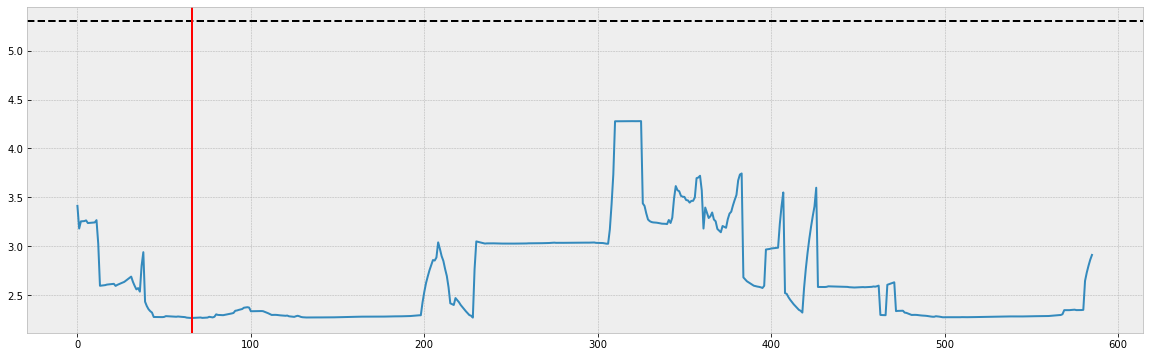

In [38]:
dtw_score_ = np.sqrt(np.array(dtw_score))
idx_min = np.argmin(dtw_score_)
dtw_min = dtw_score[idx_min]

plt.plot(dtw_score_)
plt.axhline(best_so_far, color="k", linestyle="--", label="best_so_far")
plt.axvline(idx_min, color="r", label="index_min")


### Result

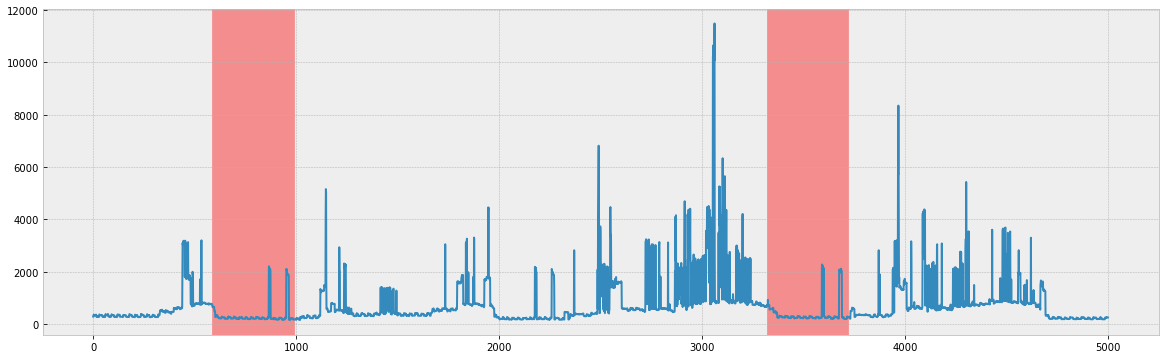

In [43]:
idx_a = candids_i[idx_min]
idx_b = candids_index[idx_min]
plt.plot(v0)
plt.axvspan(idx_a, idx_a+m, color="r", alpha=0.4)
plt.axvspan(idx_b, idx_b+m, color="r", alpha=0.4)
plt.show()

# TO DO
- [1]: Support LBkim and LBkeogh in DTW MP.  
    LBKim won't work in z-normalized. Since many indexes are pruned here, we need to discuss it.

- [2]: non-Z-normalized support?

- [3]: Comparing another dtw mask

- [4]: Interpolation in DSLBMP is currently PchipInterpolator as best option.
    For outrange suppoprt, and less smoothing not to output below min of original result.

- [5]: Optimization of dtw radius.